In [3]:
cd /content/drive/My\ Drive/Whatsapp\ Chat\ Analysis/

/content/drive/.shortcut-targets-by-id/1ymUvpbcyy9XxHjLxlR6sWaTwc-lXXR-I/Whatsapp Chat Analysis


In [40]:
 pip install emoji --upgrade

In [42]:
import re
import pandas as pd
import numpy as np
import os
pd.set_option('display.max_rows', 500)
import datetime as dt
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from collections import Counter
import string
#import emoji

import unicodedata
import nltk
#nltk.download()
#nltk.download('punkt')
#nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import  TfidfVectorizer 
from sklearn.decomposition import NMF

from collections import Counter

import warnings
warnings.filterwarnings("ignore")

In [5]:
def read(file):
    f = open('/content/drive/My Drive/Whatsapp Chat Analysis/others/{}'.format(file), 'r') 
    messages = re.findall('(\d+/\d+/\d+, \d+:\d+\d+ ([\w]+)) - (.*?): (.*)', f.read())
    f.close()
    hist = pd.DataFrame(messages,columns=['date','am-pm','name','msg'])
    hist['date'] = pd.to_datetime(hist['date'],format="%d/%m/%y, %I:%M %p")
    hist['msg_len'] = hist['msg'].str.len()
    hist['date1'] = hist['date'].apply(lambda x: x.date())
    return hist

In [6]:
files = os.listdir('/content/drive/My Drive/Whatsapp Chat Analysis/others')
lst = []
for file in files:
    history = read(file)
    lst.append(history)    
history = pd.concat(lst).reset_index()     

In [9]:
history_clean = history[history['msg']!=' <Media omitted>']

In [43]:
history_clean[history_clean['name']=='sachin']['msg'].count()

In [44]:
history_clean['name'].nunique() 

In [12]:
# Create a subset of the dataframe with only messages i've sent
msg_sachin = (history_clean[history_clean['name']=='sachin'])

In [45]:
msg_sachin.shape

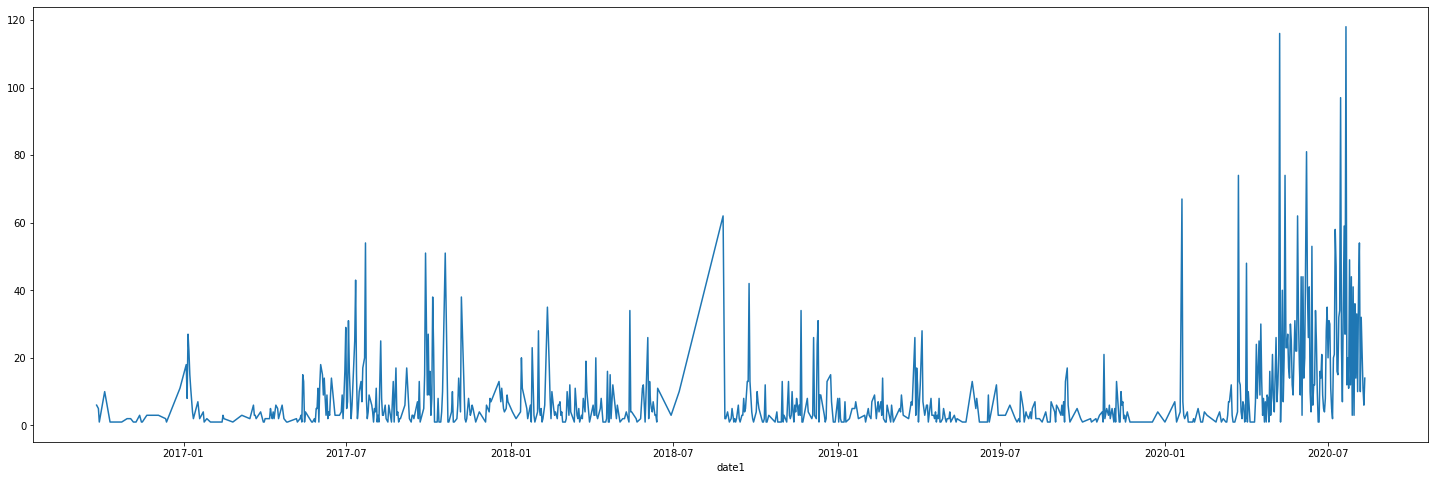

In [47]:
# Plot
plt.figure(figsize=(25,8))
msg_sachin.groupby(['date1']).count()['msg'].plot()

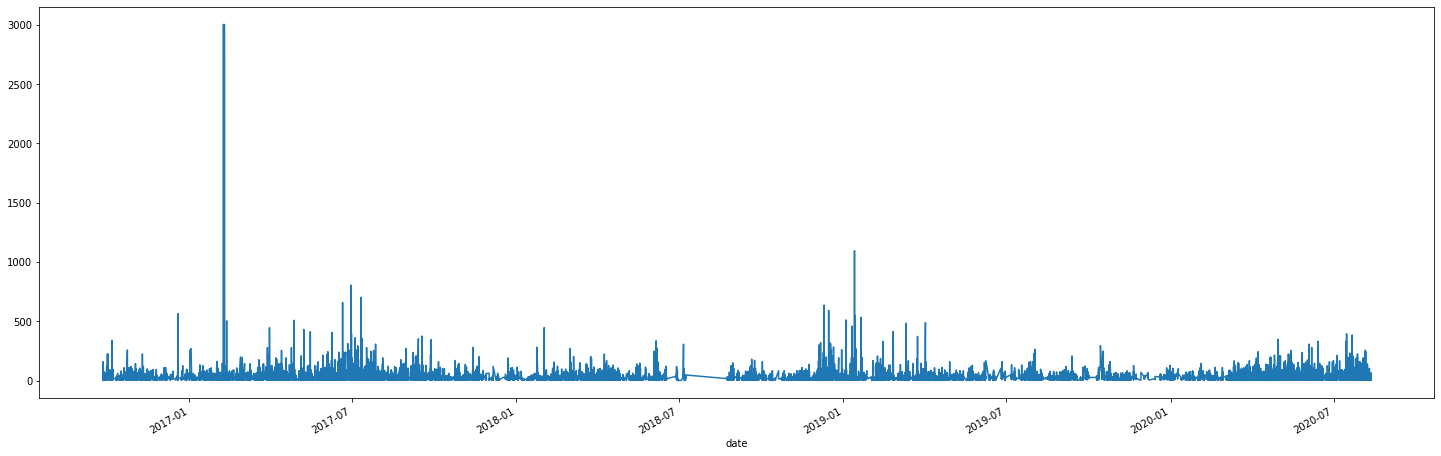

In [ ]:
plt.figure(figsize=(25,8))
history.groupby(['date'])['msg_len'].mean().plot()

In [48]:
history_clean[history_clean['msg_len'] == history_clean['msg_len'].max()]['msg'].values

In [49]:
msg_sachin['day'] = msg_sachin['date'].dt.day_name()
msg_sachin['day'].value_counts()

In [50]:
msg_sachin['datehour'] = msg_sachin['date'].dt.hour
msg_sachin['datehour'].value_counts()

In [51]:
msg_sachin['month'] = msg_sachin['date'].dt.month
msg_sachin['month'].value_counts()

In [ ]:
# Counting number of emojis
def extract_emojis(str):
    return ''.join(c for c in str if c in emoji.UNICODE_EMOJI)

def Count_Emojis(df):
    series = df['msg']
    all_words = ""
    for sentence in series:
        all_words += extract_emojis(sentence)
    word_count = Counter(all_words)
    
    
    ordered = {}
    ordered['msg'] = []
    for key, number in word_count.most_common()[:50]:
        ordered[key] = []
    
    for sentence in series:
        sentence_count = Counter(extract_emojis(sentence))
        
        for word in ordered:
            count = sentence_count[word] if sentence_count[word] else 0
            ordered[word] += [count]
    ordered['msg'] = list(series)
    ordered['date'] = list(df['date'])
    ordered['date1'] = list(df['date1'])
    ordered['name'] = list(df['name'])
    return pd.DataFrame(ordered)

In [ ]:
emojis_counts = Count_Emojis(msg_sachin)

In [ ]:
emoji_freq = emojis_counts.sum()

#NLP


In [13]:
#Sentiment Analysis
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [15]:
vds = SentimentIntensityAnalyzer()
#Example
print(vds.polarity_scores("I think he is bad "))
print(vds.polarity_scores("I think he is not that bad "))

{'neg': 0.538, 'neu': 0.462, 'pos': 0.0, 'compound': -0.5423}
{'neg': 0.0, 'neu': 0.637, 'pos': 0.363, 'compound': 0.431}


In [16]:
history_clean['sentiment'] = 0

In [53]:
for index,row in history_clean.iterrows():
  negative, neutral, positive,_ = vds.polarity_scores(row['msg']).values()
  sentiment = (positive-negative)
  history_clean.loc[index,'sentiment'] = sentiment

In [56]:
pos =0
neg =0
neut =0
for index,row in history_clean.iterrows():
  if row['sentiment']>0:
    pos = pos+1
  elif row['sentiment']<0:
    neg = neg+1
  else:
    neut = neut +1
print(pos,neg,neut)

In [25]:
history_clean['month'] = history_clean['date'].dt.month

In [26]:
msg_month = (history_clean[history_clean['month']==12])

In [55]:
msg_month['sentiment'].mean()

In [29]:
#topic modelling

def groupby_messages(data,n):
    new_data = data.sort_values(by=['date'])
    new_data['group'] = new_data.groupby(['date1','name']).cumcount()
    new_data['group'] = new_data['group'].apply(lambda x: np.floor(x/float(n)))
    new_data = new_data.groupby(['date1','name','group'])['msg'].sum().reset_index()                                
    return new_data

history_clean = groupby_messages(history_clean,5)

In [31]:
# Delete " ' '" in words 
def elimina_tildes(cadena):
    s = ''.join((c for c in unicodedata.normalize('NFD',cadena) if unicodedata.category(c) != 'Mn'))
    return s

def custom_tokenizer(text):
    remove_punct = str.maketrans('', '', string.punctuation)
    text = text.translate(remove_punct)
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)
    shortword = re.compile(r'\W*\b\w{1,2}\b')
    text = shortword.sub('', text)
    text = elimina_tildes(text)
    text = re.sub(r'([a-z])\1+', r'\1', text)
    text = re.sub(r'(ha)[ha]*', 'ha', text)
    tokens = word_tokenize(text)
    stop_words = stopwords.words('english')
    tokens_stop = [y for y in tokens if y not in stop_words]
    return tokens_stop

In [32]:
def run_NMF_model(data,max_df,n_components):
    tfidf = TfidfVectorizer(tokenizer=custom_tokenizer,max_df=max_df,min_df = 100) 
    X = tfidf.fit_transform(data)       
    nmf = NMF(n_components=n_components,random_state=0)
    doc_topics = nmf.fit_transform(X)
    t = np.argmax(doc_topics,axis=1)
    counts = pd.Series(t).value_counts()
    d = nmf.components_
    w = tfidf.get_feature_names()
    words = []
    for r in range(len(d)):
        a = sorted([(v,i) for i,v in enumerate(d[r])],reverse=True)[0:10]
        words.append([w[e[1]] for e in a])
    return doc_topics, t, words

In [33]:
doc_topics, t, words = run_NMF_model(history_clean['msg'],0.50,10)

<BarContainer object of 10 artists>

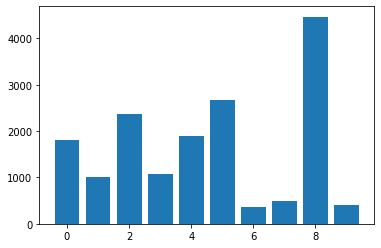

In [ ]:
t = np.argmax(doc_topics,axis=1)
plt.bar(pd.Series(t).unique(),pd.Series(t).value_counts())

In [34]:
clas = ['Group Discussion', 'Questioning', 'Bad news','Asking for help','good wishes','planning','Asking for help', 'small talk',  'academic talk', 'good wishes']

In [36]:
classification = pd.DataFrame({"topic":range(10),"classification":clas, 'words':words})

In [37]:
classification

,topic,classification,words
0,0,Group Discussion,"[media, omited, tha, gya, one, al, share, grou..."
1,1,Questioning,"[hai, raha, pas, nahi, clas, liye, aur, test, ..."
2,2,Bad news,"[bhi, nahi, toh, kar, tha, aur, raha, kuch, ko..."
3,3,Asking for help,"[kya, koi, rha, kisi, clas, raha, hoga, tha, t..."
4,4,good wishes,"[bhai, congrats, thanks, log, congratulations,..."
5,5,planning,"[wil, al, sir, get, time, one, also, clas, tak..."
6,6,Asking for help,"[mesage, deleted, group, please, send, tha, ka..."
7,7,small talk,"[omitedmedia, media, sir, kar, wala, din, raha..."
8,8,academic talk,"[nhi, clas, koi, rha, tha, kuch, test, toh, hu..."
9,9,good wishes,"[hapy, new, year, birthday, al, everyone, guys..."


In [38]:
model1 = history_clean
model1['topic'] = t
model1['sent'] = model1['name'].apply(lambda x: 'sent' if x=='Lai' else 'received')
model1 = model1.merge(classification,on='topic')

In [39]:
model1['classification'].value_counts()

Group Discussion    4467
Bad news            2672
planning            2370
academic talk       1893
Questioning         1798
good wishes         1513
Asking for help     1476
small talk           367
Name: classification, dtype: int64